# This notebook is for feature engineering!
We construct and test different features.

1. semi final qualified
2. was in top10 last year
3. rolling mean placement?

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
data = pd.read_csv("../DATA/eurovision_song_contest_1975_2018v2.csv")
# clean out trailing whitespaces!
data.columns = [d.strip() for d in data.columns]

winData = pd.read_csv("../DATA/windata.csv")
countries = pd.read_csv("../DATA/countries.csv")

In [465]:
data.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


# qualified from the SF

In [154]:
# only considering the finals
data_final = data.loc[data["(semi-) final"] == "f",]
# what country won?
dt_group = data_final.groupby(["Year","To country"])["Points"].sum()
winnerid = dt_group.reset_index().groupby(["Year"])["Points"].apply(lambda x: x.idxmax())
winners = dt_group[winnerid].reset_index()

In [155]:
winData["sf_qualify"] = np.zeros(winData.shape[0]).astype("int32")

years = np.array(winners.Year)
win = np.zeros(len(years)*countries.shape[0])

# for each year, we want the countries
year_rep = np.repeat(years, countries.shape[0])
countries_tile = np.tile(countries.index,len(years))

In [156]:
def name2Id(names):
    outvec = np.zeros(names.shape, int)
    ## for each yearly group top10
    for i in range(len(names)):
        ## for each name in each group
        #for name in top:
        outvec[i,:] = np.array([countries.loc[np.where(countries.name == name)].index.get_values() for name in names[i,:]],
                            int).reshape(1,-1)
        #print(a.shape)
    return(outvec)

In [157]:
# iterate over each year!
for y in years:
    # extract the countries in final
    inf = data.loc[(data.Year == y) & (data["(semi-) final"] == "f"),"To country"].unique()
    # the countries in any semifinal
    insf = data.loc[(data.Year == y) & (data["(semi-) final"] != "f"),"To country"].unique()
    # in both
    inboth = insf[np.isin(insf, inf)]
    # the id of the countries
    cid = name2Id(inboth.reshape(1,-1))
    #cid = countries.loc[np.isin(countries.name,inboth),].sort_values("name")["country_id"]
    # update the status
    winData.loc[(winData.year==y) & (np.isin(winData.country_id,cid)),"sf_qualify"] = 1

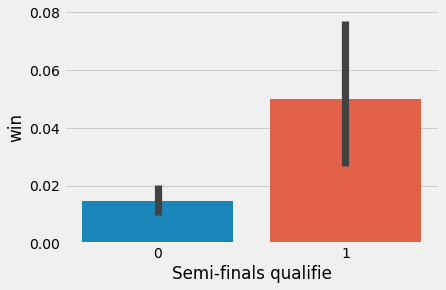

In [450]:
# If a country qualified through semifinals, will it win?
plt.style.use('fivethirtyeight')
sns.barplot(data=winData, x="sf_qualify", y="win")
plt.xlabel("Semi-finals qualifie")
pass

# placement last year?
Does the last years placement help determine how well a country perform?

In [159]:
# find which teams that were top 10 for each yeay.
dt = dt_group.reset_index()
top10 = []
for y in years:
    # find top 10 countries.
    top = dt.loc[dt.Year == y,["To country", "Points"]].sort_values("Points", ascending=False)[:10]
    top10.append(top["To country"].tolist())
top10 = np.array(top10)

In [160]:
top10_id = name2Id(top10)

In [161]:
# for each year, find select the top10 and give +1 as feature value
winData["top10_last"] = np.zeros(winData.shape[0],int)
for i, year in enumerate(years):
    # exlcude the first year
    if i > 0:
        # what countries placed top 1
        top = top10_id[i-1,]
        # select rows for year
        winData.loc[(winData.year == year) & (np.isin(winData.country_id, top)),["top10_last"]] = 1

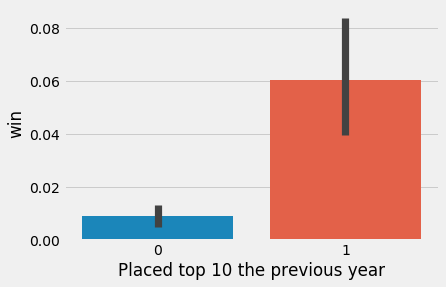

In [451]:
# If a country placed in last years top10, will it win?
plt.style.use('fivethirtyeight')
sns.barplot(data=winData, x="top10_last", y="win")
plt.xlabel("Placed top 10 the previous year")
pass

# Rolling mean placement
What is the country's current rolling mean placement?

**create matrix**
* columns: country names/ids
* rows: years
* elements: placement, if not competition (not qualified or not yet a participant) -> **NaN**

In [290]:
placement = np.zeros([len(years),len(countries)],int)
# find placement per year per country
dt = dt_group.reset_index()
for index, y in enumerate(years):
    # find placement of countries
    #print("index: ", index, " year: ", y)
    topnames = np.array(dt.loc[dt.Year == y,["To country", "Points"]].sort_values("Points", ascending=False)["To country"])
    
    # find ids (-> which column)
    topids = name2Id(topnames.reshape(1,-1))
    
    # if a country is not listed, we give it the last place.
    placement[index, :] = len(countries)+1
    # add placement in the matrix
    placement[index, topids] = pd.Series(topids.reshape(-1,)).index.get_values()+1


In [445]:
placement_df = pd.DataFrame(placement)
placement_df.columns=countries.name.tolist()
placement_df["year"] = years
placement_df = placement_df.set_index("year")
placement_df.to_csv("../DATA/placement_df.csv", index=False)

## rolling mean for two intervals!
placement_df_m10 = placement_df.rolling(10).mean()
placement_df_m20 = placement_df.rolling(20).mean()

## The distribution of mean placement.
We can see that the distribution between (mean) country placement is edging closer to uniform in later years

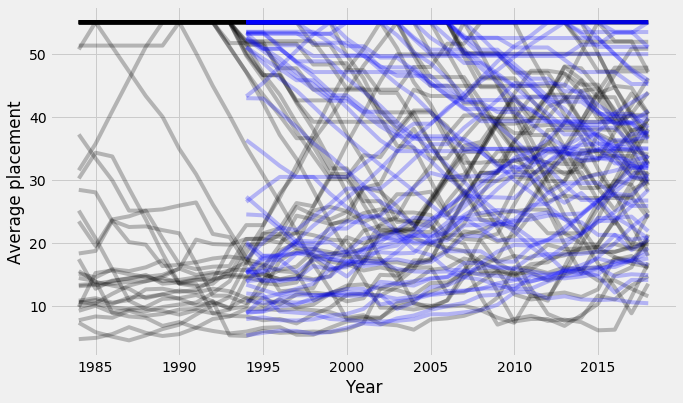

In [458]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
plt.plot(placement_df_m10, 'k', alpha = 0.25)
plt.plot(placement_df_m20, 'b', alpha=0.25)
plt.xlabel("Year")
plt.ylabel("Average placement")
pass

### it's even clearer using histograms

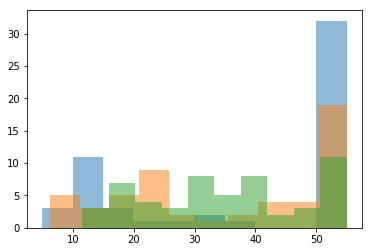

In [318]:
plt.hist(placement_df_m10.iloc[10,:], alpha=0.5)
plt.hist(placement_df_m10.iloc[-15,:], alpha=0.5)
plt.hist(placement_df_m10.iloc[-1,:], alpha=0.5)
pass

## introduce the rolling mean into the dataframe

In [364]:
winData["place_10y"] = np.zeros(len(winData))
winData["place_20y"] = np.zeros(len(winData))

In [365]:
placement_df_m10 = placement_df_m10.fillna(len(countries)+1)
placement_df_m20 = placement_df_m20.fillna(len(countries)+1)

for index, y in enumerate(years):
    winData.loc[winData.year == y,["place_10y"]] = placement_df_m10.iloc[index,].get_values()
    winData.loc[winData.year == y,["place_20y"]] = placement_df_m20.iloc[index,].get_values()

In [428]:
cats.value_counts().index.get_values()

array([Interval(44.9, 55.0, closed='right'),
       Interval(14.6, 24.7, closed='right'),
       Interval(4.45, 14.6, closed='right'),
       Interval(24.7, 34.8, closed='right'),
       Interval(34.8, 44.9, closed='right')], dtype=object)

In [439]:
labels = range(5)
bins = len(labels)

# cut the continous variables into discrete cathegories
winData["place_10y_range"] = pd.cut(winData.place_10y, bins = bins, labels=labels)
winData["place_20y_range"] = pd.cut(winData.place_20y, bins = bins, labels=labels)

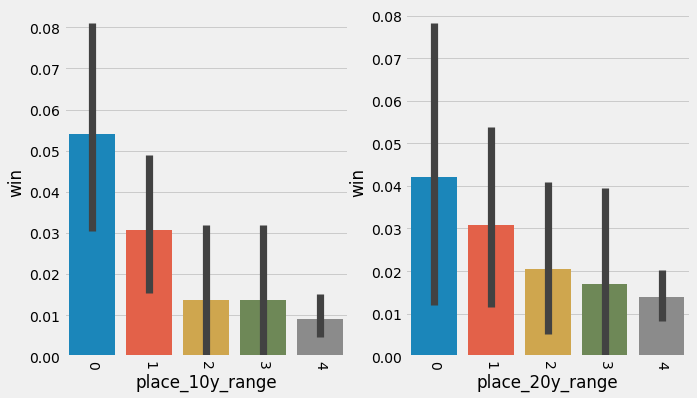

In [464]:
# If a country placed in last years top10, will it win?
f, axes = plt.subplots(1,2, figsize=[10,6])
sns.barplot(data=winData, x="place_10y_range", y="win", ax=axes[0])
#plt.xticks(rotation=90)
sns.barplot(data=winData, x="place_20y_range", y="win", ax=axes[1])
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(270)
pass

In [441]:
winData.head()

,country_id,win,year,sf_qualify,top10_last,place_10y,place_20y,place_10y_range,place_20y_range
0,0,0,1975,0,0,55.0,55.0,4,4
1,1,0,1975,0,0,55.0,55.0,4,4
2,2,0,1975,0,0,55.0,55.0,4,4
3,3,0,1975,0,0,55.0,55.0,4,4
4,4,0,1975,0,0,55.0,55.0,4,4


In [442]:
winData[['sf_qualify', 'top10_last', 'place_10y', 'place_20y',
       'place_10y_range','place_20y_range', "win"]].corr()

,sf_qualify,top10_last,place_10y,place_20y,win
sf_qualify,1.000000,0.062844,-0.241967,-0.299504,0.081854
top10_last,0.062844,1.000000,-0.391341,-0.204833,0.146257
place_10y,-0.241967,-0.391341,1.000000,0.692083,-0.106442
place_20y,-0.299504,-0.204833,0.692083,1.000000,-0.064357
win,0.081854,0.146257,-0.106442,-0.064357,1.000000


# Export dataset for prediction

In [444]:
winData.to_csv("../DATA/windata_2.csv", index=False)